# Generating virtual users

Using the papers I will list later, here's a simple model to generate artificial reviews for the recommender system I want to implement

The parameters are:

  *  Age
  *  Wealth percent
 
 
If you are in an age range or in a wealth range you are likely to spend a different amount of money on your hotel. If you chose a hotel under or over your economic standards, the rating you'll give goes down. The idea is: if the hotel is too cheap, bad. If it's more expensive than what you wanted to spend, also bad. I will use the following tables to decide the ideal hotel price for each category

In [192]:
import pandas as pd
import numpy as np
import seaborn as sns

wealth_IHP = np.array([100, 150, 200, 400, 800]) #as youare in the lowest 20% of the population, 20 to 40, and so on to 100%
age_IHP = np.array([480, 1030, 1500, 1800, 1900, 1200])*0.23*0.5 #for U25, 25-34, 35-44, 45-54, 55-64 or over65 years old


For each of the 4000 users I will create, I will assign a wealth range following a normal distribution, an age following a uniform distribution, and from there I want to pick some hotels he may have chosen for the Ideal Hotel Price associated to him/her.

I compute the IHP as the mean between wealth_IHP and age_IHP of the user's age and wealth.

To select the hotels, I have already assigned a number of ratings to make. I associate a probability distribution to pick hotels that has a triangular shape, starts from fminIHP to fmaxIHP, with fmin and fmax tuned to cover the whole price span, and the maximum at IHP. Hotels with no price information will be assigned to the lowest wealth percentiles by default (they are usually associated to cheaper hotels)

Let's start by creating the pdf:

In [193]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self,x, ihp):
        # this is a density, so we want the triangle only...
        # there are two options: I pass a list of a number for x... if x is a number, so is ihp. 
        # but if x is a list, ihp could be a float
        fmin = 0.2375 
        fmax = 2.0
        
        if isinstance(x, (int, float, complex)):
            # I just need to calcualte one prob
            h = 2/((fmax-fmin)*ihp)
            if x > fmax*ihp or x < fmin*ihp:
                prob = 0
            else:
                if x<=ihp:
                    prob = max((x-ihp*fmin)*h/(ihp*(1-fmin)),0)
                else:
                    prob= max((x-ihp*fmax)*h/(ihp*(1-fmax)),0)
            # end of ihp,x are floats
        else:
            # then we have vectors, we need to use indices
            if isinstance(ihp, (int, float, complex)):
                ihp = [ihp, ihp]
            
            h = 2/((fmax-fmin)*ihp[0])
            prob = x.copy()
            
            for i in range(len(x)):
                # if outside the limits, 0
                if x[i] > fmax*ihp[0] or x[i] < fmin*ihp[0]:
                    prob[i] = 0
                else:
                    if x[i]<=ihp[i]:
                        prob[i] = max((x[i]-ihp[0]*fmin)*h/(ihp[0]*(1-fmin)),0)
                    else:
                        prob[i]= max((x[i]-ihp[0]*fmax)*h/(ihp[0]*(1-fmax)),0)
            # end of x,ihp are lists
        return prob


my_cv = my_pdf(a=0, b=1000, name='ihp_pdf')

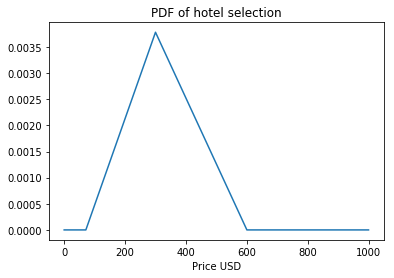

Integral of the pdf =  0.9999999866582301


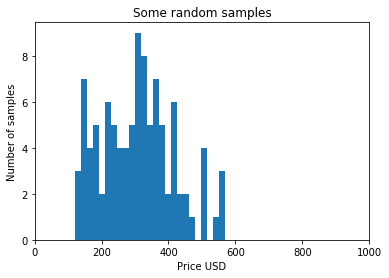

In [194]:
import matplotlib.pyplot as plt

ihp_calc = 300

x = np.linspace(0, 1000, 5000)
y = my_cv.pdf(x, ihp_calc)
plt.plot(x, y)
plt.title('PDF of hotel selection')
plt.xlabel('Price USD')
plt.show()

# make sure it integrates to 1
from scipy.integrate import simps
I1 = simps(y, x)
print('Integral of the pdf = ', I1)

# to generate random numbers:
samples = my_cv.rvs(size=100,ihp=ihp_calc)
plt.hist(samples, bins=25)
plt.xlim([0,1000])
plt.ylabel('Number of samples')
plt.xlabel('Price USD')
plt.title('Some random samples')
plt.show()

Now we are ready to generate the samples. This is the idea:

1. for every user, chose a wealth percentile and an age
2. from those, find the Ideal Hotel Price from the model
3. choose a price from the distribution, and a hotel from the list that is about that price: that's what we will rate

To rate a hotel, we define a simple equation:

overall_rating = round(mean rate + f(distance to IHP) + weak white noise)

Assume the following:
 * if distance to IHP < 50\$, f = 0
 * if 50\$ < distance to IHP < 100\$, f = -1
 * if 100\$ < distance to IHP, f = -2
 * white noise < 1.5
 * max(overall_rating) = 5.0
 
Lt's give it a shot...

In [ ]:
hotellist = pd.read_csv('Hotels_clean_merged_normalizedreviews.csv')

usrs = []
usrsage = []
usrswealth = []
usrsihp = []
hotelnames = []
hotelprices = []
hoteloriginalmeanrating = []
ratings = []

for usr in range(2000):
    # pick $$ and age fo usr
    s = np.random.normal(0, 1, 1)
    
    if s<-0.85:
        ihp_usr_wealth = wealth_IHP[0] # lowest 20% of economic power
    if s>=-0.85 and s<-0.26:
        ihp_usr_wealth = wealth_IHP[1] # 20% to 40% of economic power
    if s>=-0.26 and s<0.26:
        ihp_usr_wealth = wealth_IHP[2] # 40% to 60% of economic power
    if s>=0.26 and s<0.85:
        ihp_usr_wealth = wealth_IHP[3] # 60% to 80% of economic power
    if s>=0.85:
        ihp_usr_wealth = wealth_IHP[4] # top 20% of economic power
    
    t = np.random.randint(6, size=1)
    ihp_usr_age = age_IHP[t]
    
    # IHP for this user
    ihp_usr = 0.5*ihp_usr_wealth + 0.5* ihp_usr_age
    

    # how many ratings will this fella do? At least one tho
    numofratings = np.random.randint(9, size=1)+1
    # choose hotel prices
    prices_for_usr = my_cv.rvs(size=numofratings,ihp=ihp_usr)
    
    # for each of those prices, simply look for the closest hotel in price
    # I want hotels that have not reached the correct number of ratings...
    # generate a rating for that hotel as established by the formula
    
    for price in prices_for_usr:
        # has reviews pending
        hotelshortlist = hotellist[hotellist['nr_norm'] > 0]
        # within price range
        hotelshortlist['pricedif'] = abs(hotelshortlist['price']-price)
        hotelshortlist = hotelshortlist.sort_values(by=['pricedif'], ascending=True)
        
        # if not empty
        if not hotelshortlist.empty:
            # create rating!
            distancetoihp = hotelshortlist.iloc[0].price - ihp_usr
            
            if abs(distancetoihp)<50:
                f = 0
            else:
                if distancetoihp<250 or distancetoihp>-100:
                    f = -0.70
                else:
                    f = -1.3
            # NOW:
            rating_i_usr = np.round(float(hotelshortlist.iloc[0].overall_ratingsource + f + 1.0*np.random.rand(1)))
            if rating_i_usr>5.0:
                rating_i_usr = 5.0
            if rating_i_usr<1.0:
                rating_i_usr = 1.0
            
            # reduce the number of suggested ratings
            index_to_reduce_nrnorm = hotellist[hotellist['hotel_name'] == hotelshortlist.hotel_name.iloc[0]].index
            hotellist.nr_norm.iloc[index_to_reduce_nrnorm] = hotellist.nr_norm.iloc[index_to_reduce_nrnorm]-1.0
            
            # append everyhing to the lists
            usrs.append(usr)
            hotelnames.append(hotelshortlist.iloc[0].hotel_name)
            ratings.append(rating_i_usr)
            usrsage.append(float(t))
            usrswealth.append(float(s))
            usrsihp.append(float(ihp_usr))
            hotelprices.append(hotelshortlist.iloc[0].price)
            hoteloriginalmeanrating.append(hotelshortlist.iloc[0].overall_ratingsource)
        
        # if the shortlist is empty, ignore all...
    # now, all the prices are selected... for good or for bad
    
# here, all users have been implemented. Now I'd like to make a datframe out of the ratings
# and display it (for now)

generated_ratings_1 = pd.DataFrame(
    {'user_id': usrs,
     'user_age': usrsage,
     'user_wealth': usrswealth,
     'user_ihp':usrsihp,
     'hotel_name': hotelnames,
     'hotel_price': hotelprices,
     'hotel_original_rating': hoteloriginalmeanrating,
     'ratings': ratings
    })
generated_ratings_1.to_csv('generated_ratings_1.csv')
print('Total number of reviews', generated_ratings_1.shape[0])

/home/jonas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jonas/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/jonas/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


We want to make some stats to be sure we are not perturbing the data too much...

However, what if we do? There's no problem in that, it's just that the data it's made up, so it doesn't reflect reality (yet). When on deployment, the users data will be real, so the recommender system will work better, right? Right??

All I care is that even the means are not accurate, the trends need to be: higher price <-> higher rating

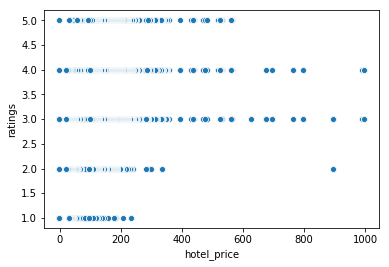

In [196]:
sns.scatterplot(x='hotel_price', y='ratings', data=generated_ratings_1)
plt.show()

Apart from that, I want to look at how many less nr_norm are there...

So I want to find all hotellist that nr_norm = 0...

Also, I want to aaverage the hotel ratings and compare with the original averages... can we do that?

In [197]:
print('Hotels fully evaluated: ', hotellist[hotellist['nr_norm']==0].shape[0])
print('Hotels with missing reviews: ', hotellist[hotellist['nr_norm']!=0].shape[0])

Hotels fully evaluated:  831
Hotels with missing reviews:  2


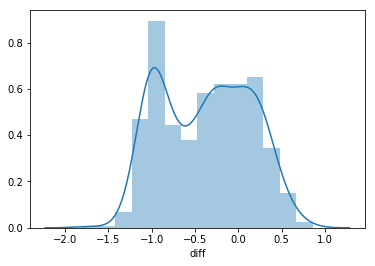

In [198]:
rat_compare = generated_ratings_1.groupby(['hotel_name']).mean()
rat_compare = rat_compare[['ratings', 'hotel_original_rating']]
rat_compare['diff'] = rat_compare['ratings'] - rat_compare['hotel_original_rating']

sns.distplot(rat_compare['diff'])
plt.show()

Ideally we want this to be a normal centered at 0, with the smallest std possible. If we had a delta on 0 it's be perfect...

I'd like to know the mean and std, to see how much we overrate the hotels

In [199]:
print('MEAN:', rat_compare['diff'].mean())
print('STD:', rat_compare['diff'].std())

MEAN: -0.381399715082259
STD: 0.5164714116247494


This means that we are not too far off from the actual means... I will take it as good for now